In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [299]:
class Attendance:
    """
    Extracts data given a directory containing reference and transient datasets as .txt files.
    
    :param string directory:
        The directory in which all of the recorded datasets are stored.
        Default is "../streams".
    :param string reference_file:
        The name of the file intended to be used as the reference dataset.
        Default is "podium.txt".
    """
    def __init__(self, directory="streams", reference_file="podium.txt"):
        self.directory = directory
        self.reference_file = reference_file
        self.reference_data = self.dictify_data(self.reference_file)
        self.operational_data = self.dictify_op_data()
        self.location_scores = self.calc_loc_scores()
        self.matrix_data = self.gen_matrix_data() # Stores y_true and y_pred
        self.con_matrix = confusion_matrix(self.matrix_data[0], self.matrix_data[1])
        self.class_report = classification_report(self.matrix_data[0], self.matrix_data[1],
                                                  target_names=['Outside', 'Inside'])
        

    def dictify_data(self, file):
        """
        Called by constructor to create reference data attribute.
        Pandas Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/index.html
        
        :param string file:
            The name of the file that contains data to be cleaned.
            Must be inside of the object's directory
            e.g. "podium.txt" or "first_row.txt".

        :return:
            A dictionary containing MAC addresses as keys and their respective received signal 
            strength indicators as values. {"a1:b2:c3:d4:e5:f6": 0, ... "f6:e5:d4:c3:b2:a1": -95}
        :rtype: dict
        """
            
        # use the object's directory attribute, and function parameter for file
        file_path = f"{self.directory}/{file}"
        # convert the text data into a dataframe, while preserving first row
        df = pd.read_csv(file_path, header=None)
        df = df.iloc[:, 3:-1] # drop device id, latitude, longitude & date columns
        df = pd.concat([ # enter hacky list comprehension pandas concatenation
            df.iloc[:, col:col+2].rename(columns={ # index mac address and rssi column pairs
                col+3: "mac_address", # index for the current mac address column
                col+4: "average_rssi" # index for the current rssi column
            }) # the column indexes from the result previous iloc, starting at 3,
            # the columns could be aligned with some transposes and resetting the index instead
            for col in range(0, len(df.columns), 2) # perform concatenation for every pair
        ], ignore_index=True)

        df.replace(0, -95, inplace=True) # replace all zero values with the -95 sensitivity
        # group by mac address and calculate the average rssi for each unique mac address
        df = df.groupby("mac_address", as_index=False)["average_rssi"].mean()
        
        try: # try except since attribute will not exist if reference data hasn't been dictified
            if self.reference_data: # only enters block for operational data
                # select only indexes where mac address is in reference dictionary keys
                df = df[df["mac_address"].isin(self.reference_data)]
                if len(df.index) != len(self.reference_data): # enters block if any indexes
                    indexes = []                              # were missing from dataframe
                    for mac in self.reference_data: # check which mac address is missing
                        if not df["mac_address"].str.contains(mac).any(): # if missing
                            indexes.append([mac, -95]) # add corresponding mac and sensitivity
                    # append newly created dataframe from missing indexes to complete it
                    df = df.append(pd.DataFrame(indexes, columns=["mac_address", "average_rssi"]))
        except:
            pass # no handling needed
        
        # sort by highest average rssi
        df.sort_values(by="average_rssi", ascending=False, inplace=True, ignore_index=True)
        df = df.head(20) # select the top 20 indexes after sorted
        
        # set the index column to the mac address and select the average rssi column,
        # allowing to_dict() to return in {mac_address: average_rssi} format
        dictified = df.set_index("mac_address")["average_rssi"].to_dict()
        
        return dictified # return completed dictionary


    def dictify_op_data(self):
        """
        Called by constructor to create the operational data attribute.
        OS Documentation: https://docs.python.org/3/library/os.html
        Pandas Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/index.html
        
        :return:
            A 2-D dictionary containing file names as keys with dictionaries containing 
            MAC addresses and their respective received signal strength indicators as values. 
            {"file_1.txt": {"a1:b2:c3:d4:e5:f6": 0,  ... "f6:e5:d4:c3:b2:a1": -95}, ...
             "file_n.txt": {"b2:c3:d4:e5:f6:a1": -45,  ... "c3:d4:e5:f6:a1:b2": -90}}
        :rtype: dict
        """
        
        dictified = {}
        
        for root, subdirs, files in os.walk(self.directory): # walk through all subdirs and files
            for file in files: # apply to all files found in the walkthrough
                # select only txt files and not the specified reference file.
                if file.endswith(".txt") and file != self.reference_file: 
                    file_path = os.path.join(root, file) # full file path including the root
                    # obtain relative path by removing root directory
                    rel_path = os.path.relpath(file_path, self.directory)
                    # convert the text data into a dataframe, while preserving first row
                    df = pd.read_csv(file_path, header=None)
                    # create new dictionary key value pair matching format
                    # {rel_path: {mac_address: average_rssi}}
                    dictified[rel_path] = self.dictify_data(rel_path)
                
        return dictified # return completed dictionary


    def calc_loc_scores(self):
        """
        Called by constructor to create the location scores attribute.
        Calculates the Euclidian Distance between reference and operational data.
        NumPy Documentation: https://numpy.org/doc/stable/reference/index.html
        
        :return:
            A dictionary containing file names as keys and their respective calculated
            euclidian distances as values. {"file_1.txt": 50.125, ... "file_n": 93.725}
        :rtype: dict
        """
        
        location_scores = {}

        # create numpy array with list comprehension, sorting keys, then adding values to list
        ref = np.array([self.reference_data[mac] for mac in sorted(self.reference_data)])
        for file, ms_pair in self.operational_data.items(): # iterate through op data dictionary
            # create numpy array with list comp, for n'th operational dataset to compare with ref
            op = np.array([ms_pair[mac] for mac in sorted(ms_pair)])
            # calculate euclidian distance with numpy's euclidian norm method
            euclidist = np.linalg.norm(ref - op)
            # add entry to return dictionary in format {file_name: euclidian_distance}
            location_scores[file] = euclidist
        
        return location_scores # return completed dictionary
    
    
    def gen_matrix_data(self):
        """
        Iterate through dicts in self.operational_data. For each rssi value, compare to threshold and 
        make a prediction which is added to y_pred list. Using the file prefix, determine whether 
        inside or outside and add to y_true list. 
        Sklearn Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        
        :return: 
            A tuple containing 2 lists, y_true and y_pred.
            
        :rtype: tuple
        """
        y_true = []
        y_pred = []
        threshold = 60.0   # The average RSSI threshold used to decide if in or out of room
        for data_set in self.operational_data:
            for rssi in self.operational_data[data_set].values():
                rssi = rssi * -1 # Make positive 
                # print(data_set[0], rssi)
                # Check whether the data set file prefix indicates inside or outside the room.  
                if data_set[0] == "i":
                    y_true.append('inside')
                else:
                    y_true.append('outside')

                # Compare the average RSSI of each access point to the threshold.
                if rssi < threshold: 
                    y_pred.append('inside')
                else:
                    y_pred.append('outside')
        return y_true, y_pred 
        
        
    def disp_con_matrix(self):
        labels = ["Outside", "Inside"]
        disp = ConfusionMatrixDisplay(confusion_matrix=self.con_matrix, display_labels=labels)
        print("n =", len(self.matrix_data[1]))
        disp.plot(cmap='Blues') 
        

In [300]:
att = Attendance("../awshene/attendance/input", "instructor.txt")

n = 280


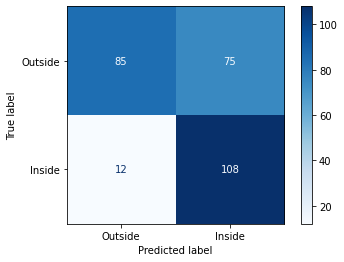

In [301]:
att.disp_con_matrix()

In [302]:
att.con_matrix

array([[ 85,  75],
       [ 12, 108]])

In [303]:
att.matrix_data

(['inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'inside',
  'i